In [4]:
import sqlite3, io,tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [362]:
sql_db_path = 'SubredditData.db'

In [363]:
connection = sqlite3.connect('SubredditData.db')
cursor = connection.cursor()

In [364]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Number of tables: {len(tables)}")

Number of tables: 850


In [365]:
df = pd.read_sql_query("SELECT * FROM AmItheAsshole", connection)

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   post_id            849 non-null    object
 1   url                849 non-null    object
 2   comment_count      849 non-null    int64 
 3   created_timestamp  849 non-null    object
 4   title              0 non-null      object
 5   ups                849 non-null    int64 
 6   author             849 non-null    object
 7   text_content       849 non-null    object
 8   post_title         849 non-null    object
dtypes: int64(2), object(7)
memory usage: 59.8+ KB


# Extract Tables

In [ ]:
comments_tables_df = []
 
for table_name in tables[1:]: # for table names
    # fetch table
    table = pd.read_sql_query(f"SELECT * FROM {table_name[0]}", connection)
 
    clean = []
    for i in table.index: #for row in df
        temp = table.iloc[i]
  
        if table.at[i, "author"]=='Judgement_Bot_AITA':
            # print(table.at[i,"author"])
            continue
        if table.at[i,"author"] == 'AutoModerator':
            # print(table.at[i,"author"])
            continue
        table.at[i, "content"] = table.at[i, "content"].decode('utf-8')
        clean.append(temp)
    comments_tables_df.append(clean)
print(len(comments_tables_df))

comments_tables_df[0]

In [ ]:
table = pd.DataFrame(comments_tables_df[2])
#print(table)
def check_single_table(table):
    print(table)
    asshole_existence = []
    table["content"] = table["content"].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
    table["content"] = table["content"].str.lower()
    comment_content = table["content"]
    table["A no A"] = None
    table.loc[comment_content.str.contains('yta',na=False), "A no A"] = 'yta'
    table.loc[comment_content.str.contains('nta', na=False), "A no A"] = 'nta'

 )
    return table
 
check_single_table(table)

In [370]:
Remove 

In [371]:
def remove_mod_comments(table_name, connection):
            table = pd.read_sql_query(f"SELECT * FROM {table_name}", connection)
            clean = []
            print("Rem Mod Type: ",type(table))
            for i in table.index: #for row in df
                temp = table.iloc[i]
       
                if table.at[i, "author"]=='Judgement_Bot_AITA':
                    continue
                if table.at[i,"author"] == 'AutoModerator':
                    continue            
                table.at[i, "content"] = table.at[i, "content"].decode('utf-8')
                clean.append(temp)
        
            return clean

In [ ]:
def make_A_no_A(tables,connection):
    
    lists_of_df = []
    for table_name in tables[1:]: # for table names, 1 is original post lists
    # fetch table
        table_name = table_name[0]
        clean_table_list = remove_mod_comments(table_name, connection)
        if clean_table_list:
            table = pd.DataFrame(clean_table_list)
            table = check_single_table(table)
        else:
            table = []
        lists_of_df.append(table)
    return lists_of_df

lists_of_df = make_A_no_A(tables,connection)

Va

In [ ]:
def get_polarity(sentences):
    
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        vs_lst.append(vs)
    return vs_lst


In [374]:

for table in lists_of_df:
    
    # add column
    if isinstance(table, list):
        continue
    polarity_list = get_polarity(table["content"])
    #print("polarity list: ", polarity_list)
    for i, pol_d in enumerate(polarity_list):
        # print(pol_d)
        # print(type(pol_d))
        compound = pol_d.pop('compound')
        table.at[i,"vader_class"] = max(pol_d, key=pol_d.get)
        table.at[i,"neu_score"] = pol_d["neu"]
        table.at[i,"pos_score"] = pol_d["pos"]
        table.at[i,"neg_score"] = pol_d["neg"]

In [377]:
# get mode of class
vader_classes_overall = []
pos_scores = []
neg_scores = []
a_no_a_list = []
for table in lists_of_df:
    if isinstance(table, list):
        pos_scores.append(None)
        neg_scores.append(None)
        a_no_a_list.append(None)
        vader_classes_overall.append(None)
        continue
    mode_vader = table["vader_class"].mode() 
    a_no_a = table["A no A"].mode() 
    if not a_no_a.empty:
        a_no_a = a_no_a[0]
    else:
        a_no_a = None
    avg_pos = table["pos_score"].mean()
    avg_neg = table["neg_score"].mean()
    pos_scores.append(avg_pos)
    neg_scores.append(avg_neg)
    a_no_a_list.append(a_no_a)
    vader_classes_overall.append(mode_vader[0])

In [378]:


counter = Counter(vader_classes_overall)


Counter({'neu': 825, None: 23, 'neg': 1})

In [379]:
pos_scores_clean = [s for s in pos_scores if s]
neg_scores_clean = [s for s in neg_scores if s]

Text(0, 0.5, 'Score')

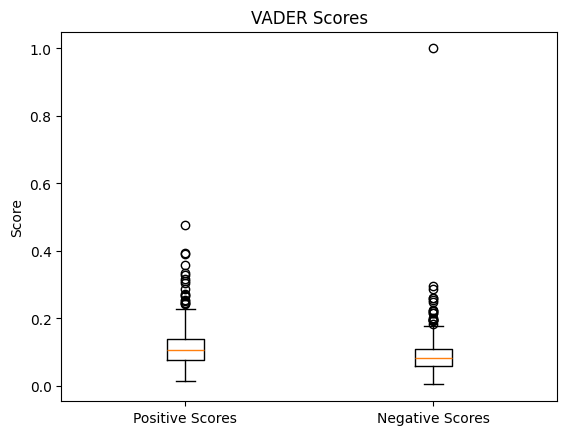

In [380]:
plt.boxplot([pos_scores_clean,neg_scores_clean],positions=[1,2])
plt.xticks([1,2],['Positive Scores','Negative Scores'])
plt.title("VADER Scores")
plt.ylabel("Score")

In [406]:
keyword_df = pd.read_csv('keyword_post.csv')

In [407]:
keyword_df.drop(["score"],axis=1,inplace=True)

In [408]:
keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  849 non-null    object
 1   text     849 non-null    object
dtypes: object(2)
memory usage: 13.4+ KB


In [409]:
keyword_df["keyword"].unique()

array(['family', 'rules', 'brother', 'uncle', 'friend', 'money', 'kids',
       'relationship', 'wedding', 'friends', 'health', 'workplace',
       'aunt', 'mother', 'stranger', 'daughter', 'presure', 'coworker',
       'wife', 'priorities', 'fiance', 'boyfriend', 'father', 'respect',
       'roommate', 'privacy', 'son', 'girlfriend', 'neighbor', 'husband',
       'pet', 'trust', 'sister', 'grandma', 'children', 'friendship',
       'boundaries', 'chores', 'disrespectful', 'responsability',
       'parents'], dtype=object)

# Group Words

In [416]:
keyword_df.loc[keyword_df["keyword"].isin(["brother","mother","kids","daughter","aunt","father","uncle","son","children","grandma","parents","sister"]),"keyword"] ="family"
keyword_df.loc[keyword_df["keyword"].isin(["friend","friendship"]),"keyword"] ="friends"
keyword_df.loc[keyword_df["keyword"].isin(["wedding","wife","husband","fiance","boyfriend","girlfriend"]),"keyword"] ="relationship"
keyword_df.loc[keyword_df["keyword"].isin(["coworker","workplace"]),"keyword"] ="work"
keyword_df.loc[keyword_df["keyword"].isin(["rules","presure","respect","priorities","trust","privacy","disrespectful"]),"keyword"] ="boundaries"
keyword_df.loc[keyword_df["keyword"].isin(["roommate","chores","responsability","neighbor"]),"keyword"] ="living"

In [417]:
keyword_df["A no A"] = a_no_a_list
keyword_df["Positive"] = pos_scores
keyword_df["Negative"] = neg_scores

In [ ]:
shape_ = keyword_df[keyword_df["A no A"]=='nta'].shape[0]
na_count = keyword_df["A no A"].isna().sum()

In [398]:
keyword_df["keyword"].unique()

array(['family', 'boundaries', 'friends', 'money', 'relationship',
       'health', 'work', 'stranger', 'living', 'pet'], dtype=object)

In [399]:
topics = ['family', 'boundaries', 'friends', 'money', 'relationship',
       'health', 'work', 'stranger', 'living', 'pet']

# Extract Gender & Age Data

In [420]:
gender_age_df = pd.read_csv('gender_age.csv')

In [421]:
gender_age_df.info()
keyword_df["Age"] = gender_age_df["Age"]
keyword_df["Gender"] = gender_age_df["Gender"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     550 non-null    float64
 1   Gender  440 non-null    object 
 2   url     849 non-null    object 
dtypes: float64(1), object(2)
memory usage: 20.0+ KB


In [402]:
 
fam = keyword_df[keyword_df["keyword"] == 'strangers']

In [403]:
f_a = fam[fam["Gender"]=='F']["Age"]
m_a =fam[fam["Gender"]=='M']["Age"]
plt.boxplot([f_a ,m_a  ],positions=[1,2])
plt.xticks([1,2],['F','M'])

In [ ]:
a_no_a_column = fam["A no A"].value_counts()
boundary = fam["A no A"].value_counts().loc['nta']
# Display the column
print(a_no_a_column)

In [428]:
keyword_df[keyword_df["keyword"]=="living"]["Age"].max() - keyword_df[keyword_df["keyword"]=="living"]["Age"].min()

30.0